# Import Modules

In [2]:
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors
import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import ttest_ind
from typing import List
import math
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import phate
import random
import sklearn.utils
import wordcloud

# Connect to Database

In [3]:
# connect to database
DB_PARAM_FILEPATH = os.path.join('C'+os.getcwd()[1:], '..', 'db_connection_params.csv')
db_params = pd.read_csv(DB_PARAM_FILEPATH)
db_host = db_params.host.iloc[0]
db_user = db_params.username.iloc[0]
db_pass = db_params.password.iloc[0]
db_name = db_params.database.iloc[0]
db_table = db_params.table.iloc[0]

print('Connecting to database...')
cnx = mysql.connector.connect(user = db_user, password = db_pass, host = db_host, database = db_name)
cursor = cnx.cursor(buffered=True)
print('Done connecting to database.')

Connecting to database...
Done connecting to database.


# Read Articles From Database

In [4]:
# read articles into dataframe
print('reading "articles" table')
query = 'SELECT * FROM articles WHERE pub_date IS NOT NULL AND source IS NOT NULL AND article_title IS NOT NULL'
# mysql package technically isn't supported, but this works fine
articles = pd.read_sql(query, cnx)
print('done reading "articles" table')
articles

reading "articles" table
done reading "articles" table

C:\Users\eeday\AppData\Local\Temp\ipykernel_23168\1549451138.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  articles = pd.read_sql(query, cnx)


,pmc_id,archive_href,abstract_text,pub_date,source,article_title
0,PMC7284390,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,the csp cell surface protein microsatellite ma...,2020-05-08,Microorganisms,Identification of CSP Types and Genotypic Vari...
1,PMC10478028,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,abstractseveral environmental chemicals are su...,2022-11-18,Cereb Cortex Commun,Fetal blockade of nicotinic acetylcholine tran...
2,PMC6494343,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,abstractchronic pulmonary aspergillosis cpa is...,2019-04-19,Medicine (Baltimore),"Evaluation of Aspergillus IgG, IgM antibody fo..."
3,PMC8501721,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,backgroundautism spectrum disorder asd is a co...,2021-10-09,BMC Neurosci,A systematic review of common genetic variatio...
4,PMC9620685,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,background and aimstrategies to modify and adj...,2022-09-21,Autism Dev Lang Impair,Strategies in supporting inclusive education f...
...,...,...,...,...,...,...
8654,PMC10137878,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,parenting a child with autism spectrum disorde...,2023-04-21,Healthcare (Basel),Qualitative Investigation into the Perception ...
8655,PMC5085789,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,since involved in synaptic transmission and lo...,2016-10-22,Int J Mol Sci,Association Analysis of Noncoding Variants in ...
8656,PMC8421761,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,background autism spectrum disorder asd or aut...,2021-08-24,Front Psychiatry,"A Phase II Randomized, Double-Blind, Placebo-C..."
8657,PMC8464598,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,theory of mind tom deficits are common in chil...,2021-09-25,Transl Psychiatry,Do shapes have feelings? Social attribution in...


# Filter Articles
Need a set of articles without Aspergillus in title.

In [5]:
asd_search_terms = ['autis', 'asperger']

# filter out any articles which don't have autis* or asperger in title
filtered_articles = articles[articles["article_title"].str.contains('|'.join(asd_search_terms))]
filtered_articles

,pmc_id,archive_href,abstract_text,pub_date,source,article_title
1,PMC10478028,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,abstractseveral environmental chemicals are su...,2022-11-18,Cereb Cortex Commun,Fetal blockade of nicotinic acetylcholine tran...
3,PMC8501721,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,backgroundautism spectrum disorder asd is a co...,2021-10-09,BMC Neurosci,A systematic review of common genetic variatio...
4,PMC9620685,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,background and aimstrategies to modify and adj...,2022-09-21,Autism Dev Lang Impair,Strategies in supporting inclusive education f...
5,PMC8162135,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,this exploratory study aimed to explore the as...,2020-08-08,Autism,"Timing of diagnosis, depression and self-harm ..."
8,PMC10150704,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,importancesleep disorders are one of the most ...,2023-04-17,Front Psychiatry,Identification of atypical sleep microarchitec...
...,...,...,...,...,...,...
8643,PMC8686326,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,autism specific transition resources tres\naim...,2021-01-28,HRB Open Res,Study protocol for autism specific transition ...
8648,PMC10406950,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,despite many differences autism spectrum disor...,2023-08-07,Sci Rep,Association between increased anterior cingula...
8652,PMC6298000,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,background\nenvironmental factors can modify t...,2018-12-17,BMC Neurosci,Offline encoding impaired by epigenetic regula...
8653,PMC6529696,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,prebiotic dietary watersoluble fiber obtained ...,2019-03-07,J Clin Biochem Nutr,Dietary supplementation with partially hydroly...


# Extract Corpus
We need to extract all abstracts to create a corpus.

In [6]:
# extract corpus
abstracts = list(articles.abstract_text)
filtered_abstracts = list(filtered_articles.abstract_text)

In [7]:
print('Working with {0} filtered articles out of {1}'.format(len(filtered_abstracts), len(abstracts)))

Working with 2680 filtered articles out of 8659


# Convert to Word Embeddings
We'll be using the Google News pre-trained word embeddings model.

In [8]:
WORD_EMBEDDINGS_FILEPATH = os.path.join('..', 'word_embeddings', 'GoogleNews-vectors-negative300.bin')
gn_vectors = KeyedVectors.load_word2vec_format(WORD_EMBEDDINGS_FILEPATH, binary=True)

Let's define a function which averages word embedding vectors across a text.

In [9]:
def get_text_avg(word_vectors: KeyedVectors, text: str) -> np.array:
    # get list of words in text
    wl = [i.strip() for i in text.split()]
    
    # initial word vector list
    wvl = []

    for word in wl:
        try:
            wvl.append(word_vectors[word])
        except KeyError:
            # word not present, continue
            continue
    
    return np.mean(np.array(wvl), axis=0)

# Perform K-Means Clustering

To make this easier, we'll be using some code from https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/.

In [10]:
def mbkmeans_clusters(
	X,
    k: int,
    mb: int,
    print_silhouette_values: bool, 
    seed: int = 42
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb, random_state=seed).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_, silhouette_score(X, km.labels_)

Let's get our word embeddings for all documents:

In [11]:
non_asg_we = [get_text_avg(gn_vectors, i) for i in filtered_abstracts]

Based on our results from the validation notebook, we'll use four clusters.

In [12]:
num_clusters = 4

In [13]:
clustering, cluster_labels, sil_score = mbkmeans_clusters(X=non_asg_we,
                                            k=num_clusters,
                                            mb = len(non_asg_we),
                                            print_silhouette_values=True,
                                            seed=13)


For n_clusters = 4
Silhouette coefficient: 0.07
Inertia:356.0877809190362
Silhouette values:
    Cluster 1: Size:844 | Avg:0.10 | Min:-0.10 | Max: 0.21
    Cluster 0: Size:687 | Avg:0.08 | Min:-0.09 | Max: 0.25
    Cluster 2: Size:6 | Avg:0.06 | Min:0.03 | Max: 0.11
    Cluster 3: Size:1143 | Avg:0.04 | Min:-0.10 | Max: 0.14


Let's now get the most representative tokens per cluster.

In [14]:
print('most representative terms per cluster (based on centroids):')
for i in range(num_clusters):
    tokens_per_cluster = ''
    most_representative = gn_vectors.most_similar(positive = [clustering.cluster_centers_[i]], topn = 10)
    for t in most_representative:
        tokens_per_cluster += f'{t[0]} '
    print(f'Cluster {i}: {tokens_per_cluster}')

most representative terms per cluster (based on centroids):
Cluster 0: Genetic_predisposition DNA_methylation_patterns glial_tumors underlying_pathophysiology familial_clustering maturational clefting phenotypic_expression dysfunction_Zada Genetic_variants 
Cluster 1: %_#F########_9v.jsn By_Jonas_Elmerraji By_Laurelle_Gilbert %_#F########_3v.jsn By_Christine_Fenno By_Elise_Viebeck BY_ANDY_THOMPSON Club_Stairways_Comprehensive By_Joseph_Woelfel By_Kat_Zeman 
Cluster 2: Club_Stairways_Comprehensive Disordered_eating Irritability_anxiety_cognitive Cerebral_palsy_involves By_Christine_Fenno %_#F########_9v.jsn By_Elise_Viebeck neuropsychological_impairments By_Laurelle_Gilbert dysfunction_Zada 
Cluster 3: By_Jonas_Elmerraji By_Laurelle_Gilbert By_Elise_Viebeck By_Christine_Fenno DIRECTORS_OF_CAPITAL_CORP. By_Joseph_Woelfel By_Laurie_Kulikowski %_#F########_9v.jsn By_Kat_Zeman %_#F########_3v.jsn 


Utter nonsense. How about the most representative documents?

In [15]:
for i in range(num_clusters):
    most_representative_docs = np.argsort(
        np.linalg.norm(non_asg_we - clustering.cluster_centers_[i], axis=1)
    )
    print(f'Cluster {i}')
    for d in most_representative_docs[:3]:
        print(filtered_abstracts[d])
        print('---------------------')
    print()

Cluster 0
backgroundautism spectrum disorders asds represent a heterogeneous group of disorders with a wide range of behavioral impairments including social and communication deficits apart from these core symptoms a significant number of asd individuals display higher levels of anxiety and some studies indicate that a subset of asd individuals have a reduced ability to be fear conditioned deciphering the molecular basis of asd has been considerably challenging and it currently remains poorly understood in this study we examined the molecular basis of autismlike impairments in an environmentally induced animal model of asd where pregnant rats are exposed to the known teratogen valproic acid vpa on day 125 of gestation and the subsequent progeny exhibit asdlike symptoms we focused our analysis on the basal and lateral nucleus of the amygdala bla a region of the brain found to be associated with asd pathologymethodswe performed whole genome gene expression analysis on the bla using dna m

Yup, there it is!
These actually appear to be segregating in a much more reasonable way!
Now let's plot this.

## K-Means Plotting - Validation

In [16]:
u_cluster_labels = np.unique(cluster_labels)

In [17]:
all_colors = list(mcolors.BASE_COLORS.keys())
print(len(all_colors))
all_labels = ['o', 'x', '+', 'D', 'v', '1', 's']
color_set = []
marker_set = []
for i in u_cluster_labels:
    color_set.append(all_colors[i % len(all_colors)])
    marker_set.append(all_labels[i % len(all_labels)])
print(color_set)
print(marker_set)

8
['b', 'g', 'r', 'c']
['o', 'x', '+', 'D']


In [18]:
len(non_asg_we[0])

300

To visualize these 300D vectors, we need to use a dimensionality reduction algorithm that preserves high-order structure. Let's try using PHATE.

In [19]:
po = phate.PHATE()
ph_all_we = po.fit_transform(np.array(non_asg_we))

Calculating PHATE...
  Running PHATE on 2680 observations and 300 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...


    Calculated PCA in 0.50 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.62 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 1.19 seconds.
  Calculating landmark operator...
    Calculating SVD...


c:\Users\eeday\AppData\Local\Programs\Python\Python312\Lib\site-packages\graphtools\graphs.py:290: RuntimeWarning: Detected zero distance between 27 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
c:\Users\eeday\AppData\Local\Programs\Python\Python312\Lib\site-packages\graphtools\graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated SVD in 1.05 seconds.
    Calculating KMeans...
    Calculated KMeans in 5.34 seconds.
  Calculated landmark operator in 7.15 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 7.46 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.82 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.81 seconds.
Calculated PHATE in 21.44 seconds.


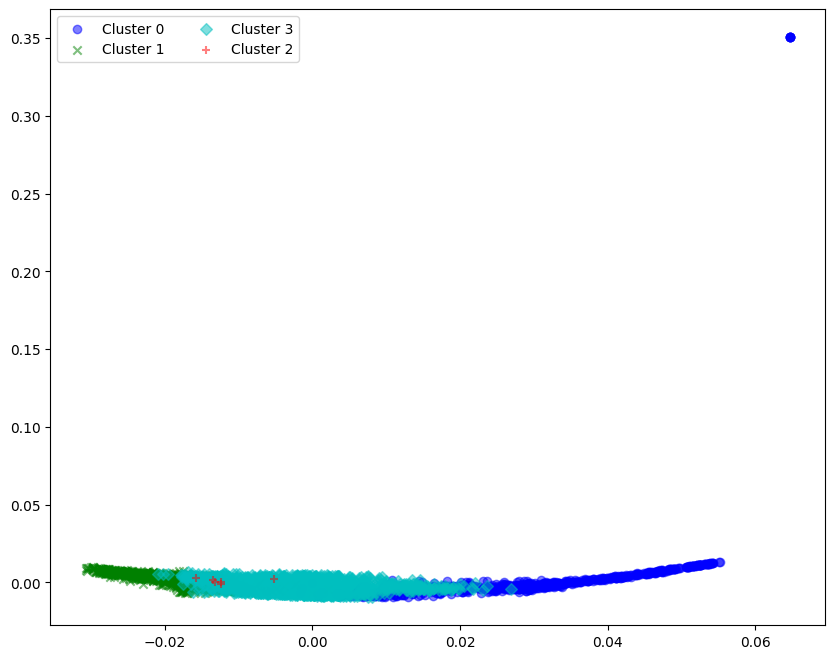

In [20]:
plt.figure(figsize=(10,8))
u_cluster_labels_reordered = [0, 1, 3, 2]
for i in u_cluster_labels_reordered:
    plt.scatter(ph_all_we[cluster_labels == i, 0], ph_all_we[cluster_labels == i, 1], label=f'Cluster {i}', c=color_set[i], marker=marker_set[i], alpha=0.5)
plt.legend(fontsize = 10, ncol = 2)
plt.show()

Although the clustering that PHATE uses is different from the way that K-Means tends to cluster, it appears to be clustering in a reasonable way.

# Source Descriptor Labeling

Let's enrich our clusters with information about the article sources from the `source_descriptors` table.

In [21]:
# read source_descriptors into dataframe
print('reading "source_descriptors" table')
query = 'SELECT * FROM source_descriptors'
# mysql package technically isn't supported, but this works fine
source_descriptors = pd.read_sql(query, cnx)
print('done reading "source_descriptors" table')
source_descriptors

reading "source_descriptors" table
done reading "source_descriptors" table


C:\Users\eeday\AppData\Local\Temp\ipykernel_23168\4110111789.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  source_descriptors = pd.read_sql(query, cnx)


,ncbi_source_id,medline_ta,descriptor,source_title
0,101774029,Sleep Adv,Sleep Wake Disorders,Sleep advances : a journal of the Sleep Resear...
1,101774029,Sleep Adv,Sleep,Sleep advances : a journal of the Sleep Resear...
2,101731738,NPJ Digit Med,Medical Informatics,NPJ digital medicine.
3,101709029,Adv Neurodev Disord,Neurodevelopmental Disorders,Advances in neurodevelopmental disorders.
4,101672561,Chin Neurosurg J,Nervous System Diseases,Chinese neurosurgical journal.
...,...,...,...,...
2382,0315061,Antimicrob Agents Chemother,Drug Therapy,Antimicrobial agents and chemotherapy.
2383,0251711,Behav Genet,"Genetics, Behavioral",Behavior genetics.
2384,0414003,Yonsei Med J,Medicine,Yonsei medical journal.
2385,7505876,Proc Natl Acad Sci U S A,Science,Proceedings of the National Academy of Science...


One way to visualize this is via word clouds. Let's make a word cloud of the descriptors, sources and abstract words associated with each cluster.

First, we need to turn our abstracts into a Series for easier selection.

In [22]:
filtered_abstracts_s = pd.Series(filtered_abstracts)

## Cluster 0

First, the abstracts:

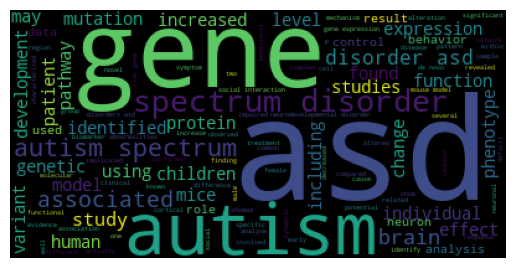

In [23]:
# join together all abstracts in cluster 0
c0_text = ' '.join(filtered_abstracts_s[cluster_labels == 0])

# generate and plot wordcloud
wc_c0_abs = wordcloud.WordCloud().generate(c0_text)
plt.imshow(wc_c0_abs)
plt.axis('off')
plt.show()

Then the sources:

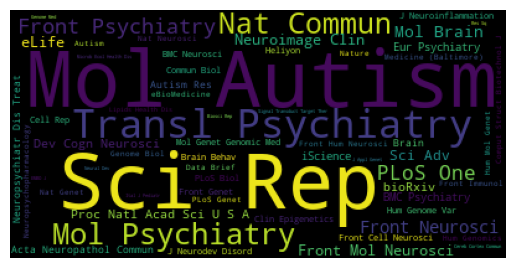

In [24]:
# get all medline_ta's
c0_medline_tas = filtered_articles.source[cluster_labels == 0]

# generate frequencies
c0_mt_freqs = {i: list(c0_medline_tas).count(i) for i in c0_medline_tas}

# generate and plot wordcloud
wc_c0_desc = wordcloud.WordCloud().generate_from_frequencies(c0_mt_freqs)
plt.imshow(wc_c0_desc)
plt.axis('off')
plt.show()

Then the descriptors:

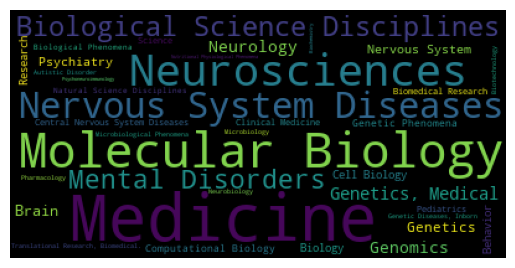

In [26]:
# get all descriptors
c0_descriptors = list(source_descriptors.descriptor[source_descriptors.medline_ta.isin(c0_medline_tas)])

# generate frequencies
c0_desc_freqs = {i: list(c0_descriptors).count(i) for i in c0_descriptors}

# generate and plot wordcloud
wc_c0_desc = wordcloud.WordCloud().generate_from_frequencies(c0_desc_freqs)
plt.imshow(wc_c0_desc)
plt.axis('off')
plt.show()

## Cluster 1

First, the abstracts:

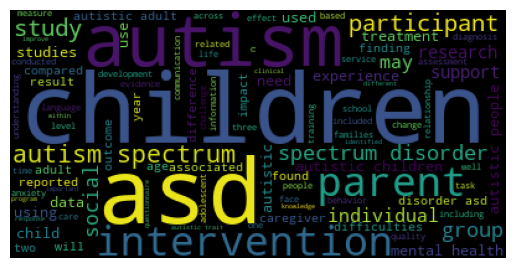

In [27]:
# join together all abstracts in cluster 0
c1_text = ' '.join(filtered_abstracts_s[cluster_labels == 1])

# generate and plot wordcloud
wc_c1_abs = wordcloud.WordCloud().generate(c1_text)
plt.imshow(wc_c1_abs)
plt.axis('off')
plt.show()

Then the sources:

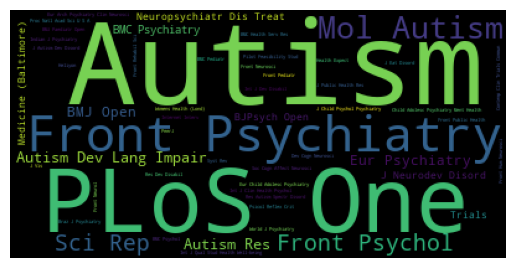

In [29]:
# get all medline_ta's
c1_medline_tas = filtered_articles.source[cluster_labels == 1]

# generate frequencies
c1_mt_freqs = {i: list(c1_medline_tas).count(i) for i in c1_medline_tas}

# generate and plot wordcloud
wc_c1_desc = wordcloud.WordCloud().generate_from_frequencies(c1_mt_freqs)
plt.imshow(wc_c1_desc)
plt.axis('off')
plt.show()

Then the descriptors:

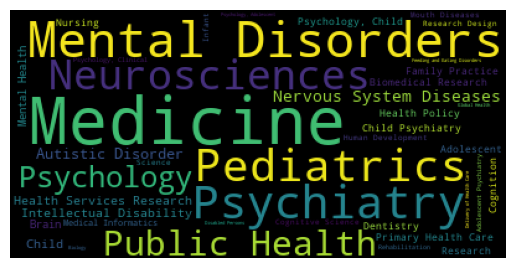

In [30]:
# get all descriptors
c1_descriptors = list(source_descriptors.descriptor[source_descriptors.medline_ta.isin(c1_medline_tas)])

# generate frequencies
c1_desc_freqs = {i: list(c1_descriptors).count(i) for i in c1_descriptors}

# generate and plot wordcloud
wc_c1_desc = wordcloud.WordCloud().generate_from_frequencies(c1_desc_freqs)
plt.imshow(wc_c1_desc)
plt.axis('off')
plt.show()

## Cluster 2

First, the abstracts:

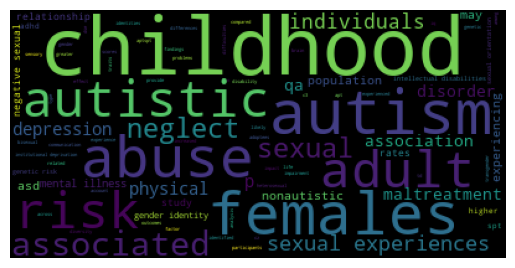

In [31]:
# join together all abstracts in cluster 2
c2_text = ' '.join(filtered_abstracts_s[cluster_labels == 2])

# generate and plot wordcloud
wc_c2_abs = wordcloud.WordCloud().generate(c2_text)
plt.imshow(wc_c2_abs)
plt.axis('off')
plt.show()

Then the sources:

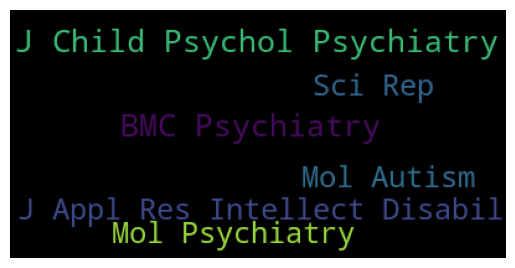

In [32]:
# get all medline_ta's
c2_medline_tas = filtered_articles.source[cluster_labels == 2]

# generate frequencies
c2_mt_freqs = {i: list(c2_medline_tas).count(i) for i in c2_medline_tas}

# generate and plot wordcloud
wc_c2_desc = wordcloud.WordCloud().generate_from_frequencies(c2_mt_freqs)
plt.imshow(wc_c2_desc)
plt.axis('off')
plt.show()

Then the descriptors:

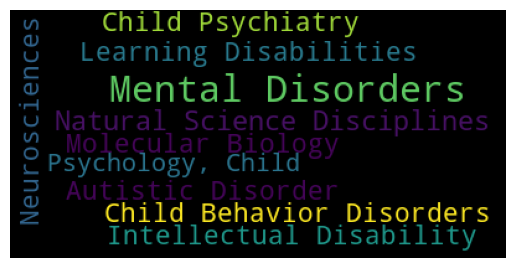

In [34]:
# get all descriptors
c2_descriptors = list(source_descriptors.descriptor[source_descriptors.medline_ta.isin(c2_medline_tas)])

# generate frequencies
c2_desc_freqs = {i: list(c2_descriptors).count(i) for i in c2_descriptors}

# generate and plot wordcloud
wc_c2_desc = wordcloud.WordCloud().generate_from_frequencies(c2_desc_freqs)
plt.imshow(wc_c2_desc)
plt.axis('off')
plt.show()

## Cluster 3

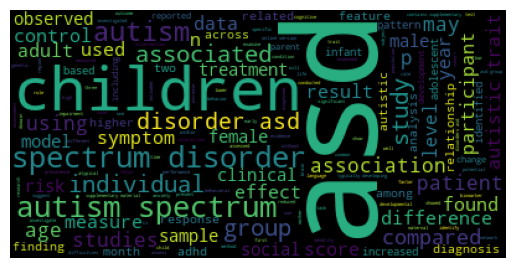

In [35]:
# join together all abstracts in cluster 3
c3_text = ' '.join(filtered_abstracts_s[cluster_labels == 3])

# generate and plot wordcloud
wc_c3_abs = wordcloud.WordCloud().generate(c3_text)
plt.imshow(wc_c3_abs)
plt.axis('off')
plt.show()

Then the sources:

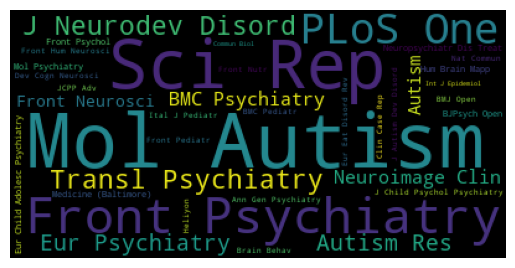

In [36]:
# get all medline_ta's
c3_medline_tas = filtered_articles.source[cluster_labels == 3]

# generate frequencies
c3_mt_freqs = {i: list(c3_medline_tas).count(i) for i in c3_medline_tas}

# generate and plot wordcloud
wc_c3_desc = wordcloud.WordCloud().generate_from_frequencies(c3_mt_freqs)
plt.imshow(wc_c3_desc)
plt.axis('off')
plt.show()

Then the descriptors:

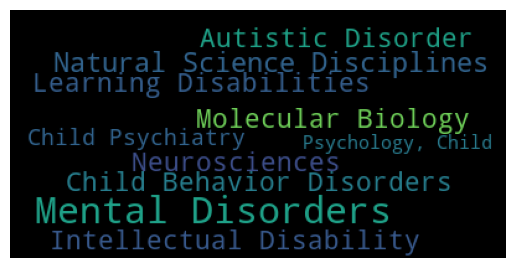

In [37]:
# get all descriptors
c2_descriptors = list(source_descriptors.descriptor[source_descriptors.medline_ta.isin(c2_medline_tas)])

# generate frequencies
c2_desc_freqs = {i: list(c2_descriptors).count(i) for i in c2_descriptors}

# generate and plot wordcloud
wc_c2_desc = wordcloud.WordCloud().generate_from_frequencies(c2_desc_freqs)
plt.imshow(wc_c2_desc)
plt.axis('off')
plt.show()